In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packaging import version
from tensorflow.keras import layers, models, backend as k
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import re
import string
import time

In [ ]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

TensorFlow version:  2.15.0


In [ ]:
!tfds build --register_checksums --datasets=ag_news_subset

Traceback (most recent call last):
  File "/usr/local/bin/tfds", line 5, in <module>
    from tensorflow_datasets.scripts.cli.main import launch_cli
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/main.py", line 37, in <module>
    from tensorflow_datasets.scripts.cli import convert_format
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format.py", line 32, in <module>
    from tensorflow_datasets.scripts.cli import convert_format_utils
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format_utils.py", line 169, in <module>
    pipeline: beam.Pipeline | None = None,
  File "/usr/local/lib/python3.10/dist-packages/etils/epy/lazy_imports_utils.py", line 90, in __getattr__
    return getattr(self._module, name)
  File "/usr/lib/python3.10/functools.py", line 981, in __get__
    val = self.func(instance)
  File "/usr/local/lib/python3.10/dist-packages/etils/epy/lazy_imports_utils.

In [ ]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.3TH2LD_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.3TH2LD_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Check the dataframe
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
# Check the categories
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [ ]:
# Review Class Balance
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [ ]:
# Text Vectorization and Vocabulary Adaptation
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [ ]:
def create_bidirectional_model(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
def train_and_evaluate_bidirectional_model(vocab_size, text_vectorization, output_sequence_length, model_name):
    print(f"Starting experiment: {model_name} with vocab size {vocab_size}")

    # Prepare the dataset
    def vectorize_text(text, label):
        text = text_vectorization(text)
        return text, label

    vectorized_dataset = dataset_all.map(vectorize_text)
    vectorized_dataset = vectorized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split the dataset
    dataset_size = len(list(vectorized_dataset))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = vectorized_dataset.take(train_size).batch(32)
    val_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

    # Train the model
    model = create_bidirectional_model(vocab_size, output_sequence_length)  # Use the bidirectional model creation function
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
    start_time = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)
    training_time = time.time() - start_time

    # Evaluate on validation dataset
    val_loss, val_accuracy = model.evaluate(val_dataset)

    # Load the best model and evaluate on validation dataset
    model = tf.keras.models.load_model(f"{model_name}.h5")
    test_loss, test_accuracy = model.evaluate(val_dataset)

    # Collect final train accuracy and loss
    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]

    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_time': training_time,
        'val_acc': val_accuracy,
        'val_loss': val_loss,
        'test_acc': test_accuracy,
        'test_loss': test_loss,
        'history': history  # Ensure history is returned
    }


In [ ]:
# Experiment with unedited and edited vocabularies
experiments = [
    {"name": "unedited", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100},
    {"name": "edited", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": custom_stopwords, "output_sequence_length": 100},
    {"name": "unedited_fixed_length", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100},
    {"name": "edited_fixed_length", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": custom_stopwords, "output_sequence_length": 100}
]

In [ ]:
# Collecting results for bidirectional model
all_results_bidirectional = []
for experiment in experiments:
    for vocab_size in experiment["vocab_sizes"]:
        try:
            text_vectorization = text_vectorization_and_adapt(
                dataset_all.map(lambda text, label: text),
                max_tokens=vocab_size,
                standardize_fn=experiment["standardize_fn"],
                output_sequence_length=experiment["output_sequence_length"]
            )
            results = train_and_evaluate_bidirectional_model(vocab_size, text_vectorization, experiment["output_sequence_length"], experiment["name"])
            all_results_bidirectional.append({
                "experiment": experiment["name"],
                "vocab_size": vocab_size,
                "results": results
            })
        except ValueError as e:
            print(f"Error with vocab_size {vocab_size}: {e}")


Starting experiment: unedited with vocab size 5000
Epoch 1/200
3190/3190 [==============================] - 53s 15ms/step - loss: 0.4710 - accuracy: 0.8354 - val_loss: 0.3404 - val_accuracy: 0.8783
Epoch 2/200
  11/3190 [..............................] - ETA: 33s - loss: 0.3952 - accuracy: 0.8693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3190/3190 [==============================] - 38s 12ms/step - loss: 0.3338 - accuracy: 0.8906 - val_loss: 0.3133 - val_accuracy: 0.8872
Epoch 3/200
3190/3190 [==============================] - 38s 12ms/step - loss: 0.3008 - accuracy: 0.9009 - val_loss: 0.3103 - val_accuracy: 0.8922
Epoch 4/200
3190/3190 [==============================] - 38s 12ms/step - loss: 0.2767 - accuracy: 0.9102 - val_loss: 0.3058 - val_accuracy: 0.8958
Epoch 5/200
3190/3190 [==============================] - 38s 12ms/step - loss: 0.2584 - accuracy: 0.9166 - val_loss: 0.3161 - val_accuracy: 0.8973
Epoch 6/200
3190/3190 [==============================] - 38s 12ms/step - loss: 0.2432 - accuracy: 0.9220 - val_loss: 0.3118 - val_accuracy: 0.8982
Epoch 7/200
3190/3190 [==============================] - 38s 12ms/step - loss: 0.2290 - accuracy: 0.9264 - val_loss: 0.3311 - val_accuracy: 0.8963
Epoch 8/200
3190/3190 [==============================] - 38s 12ms/step - loss: 0.2150 - accuracy: 0.9316 - val_loss: 0.3480 - val_

In [ ]:
# Create a DataFrame to display the results
df_bidirectional = pd.DataFrame([{
    'experiment': res['experiment'],
    'vocab_size': res['vocab_size'],
    'model_name': res['results']['model_name'],
    'train_acc': res['results']['train_acc'],
    'train_loss': res['results']['train_loss'],
    'train_time': res['results']['train_time'],
    'val_acc': res['results']['val_acc'],
    'val_loss': res['results']['val_loss'],
    'test_acc': res['results']['test_acc'],
    'test_loss': res['results']['test_loss']
} for res in all_results_bidirectional])

In [ ]:
# Adjust display settings for better alignment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Display the DataFrame
print(df_bidirectional)

               experiment  vocab_size             model_name  train_acc  train_loss  train_time   val_acc  val_loss  test_acc  test_loss
0                unedited        5000               unedited   0.936511    0.202667  357.532724  0.890243  0.378180  0.895807   0.305814
1                unedited       10000               unedited   0.947727    0.173965  282.087231  0.897884  0.361793  0.902194   0.290347
2                unedited       20000               unedited   0.957524    0.145136  245.779977  0.902978  0.336206  0.904036   0.283540
3                  edited        5000                 edited   0.932602    0.216935  282.745894  0.898785  0.310086  0.900666   0.289478
4                  edited       10000                 edited   0.954428    0.154866  325.464643  0.900901  0.342488  0.907915   0.277142
5                  edited       20000                 edited   0.967584    0.117389  310.916837  0.896003  0.419039  0.907053   0.277836
6   unedited_fixed_length        5000  un

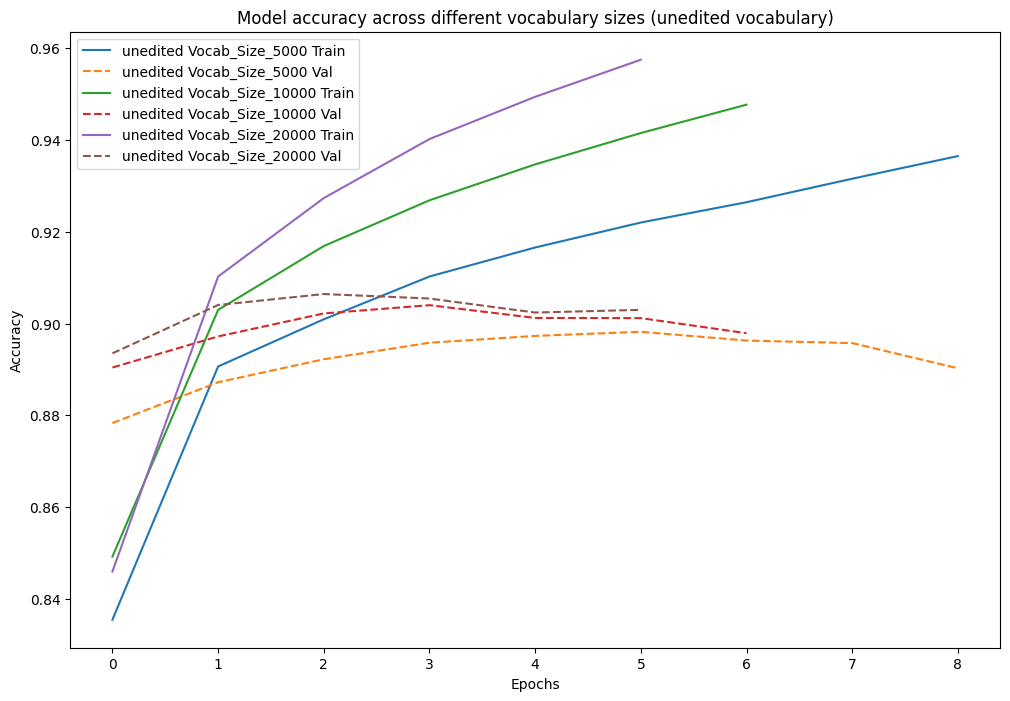

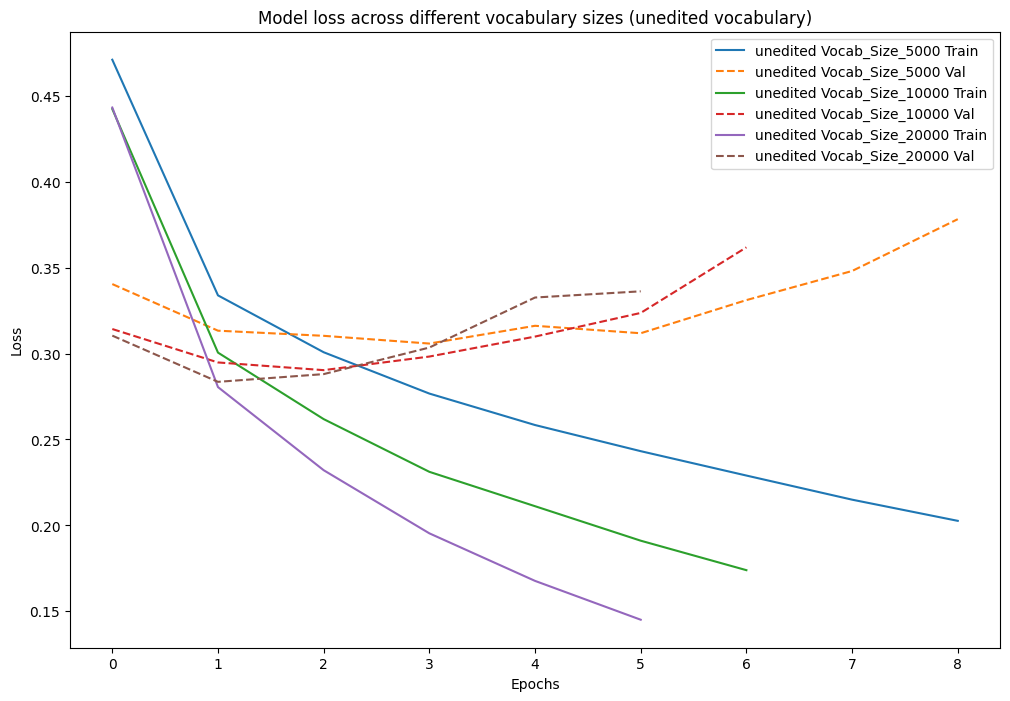

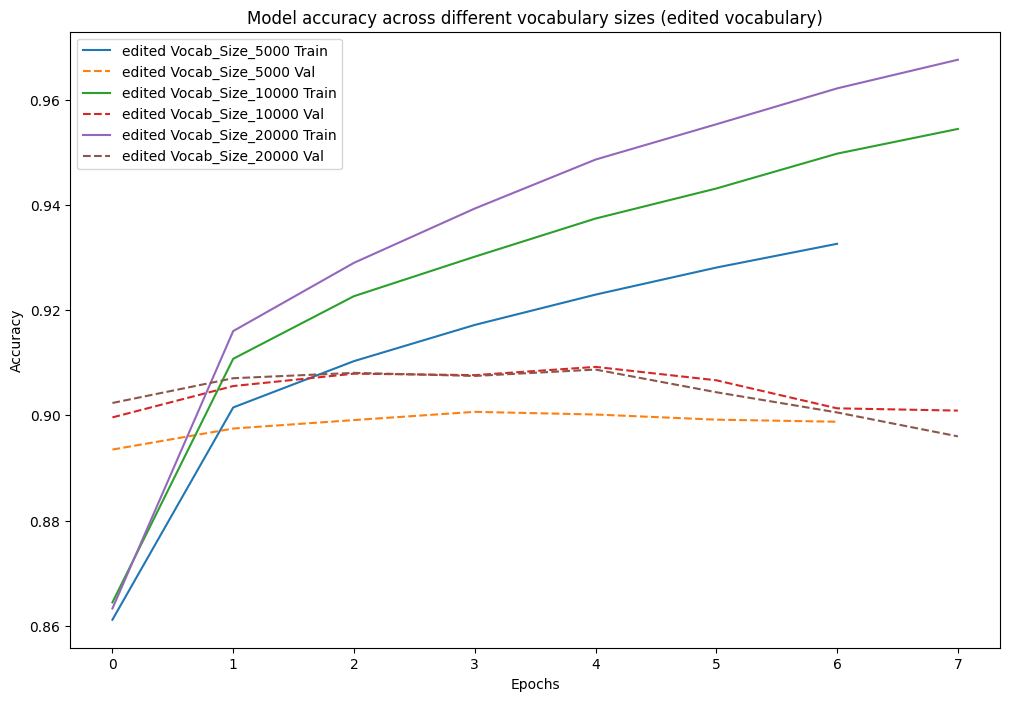

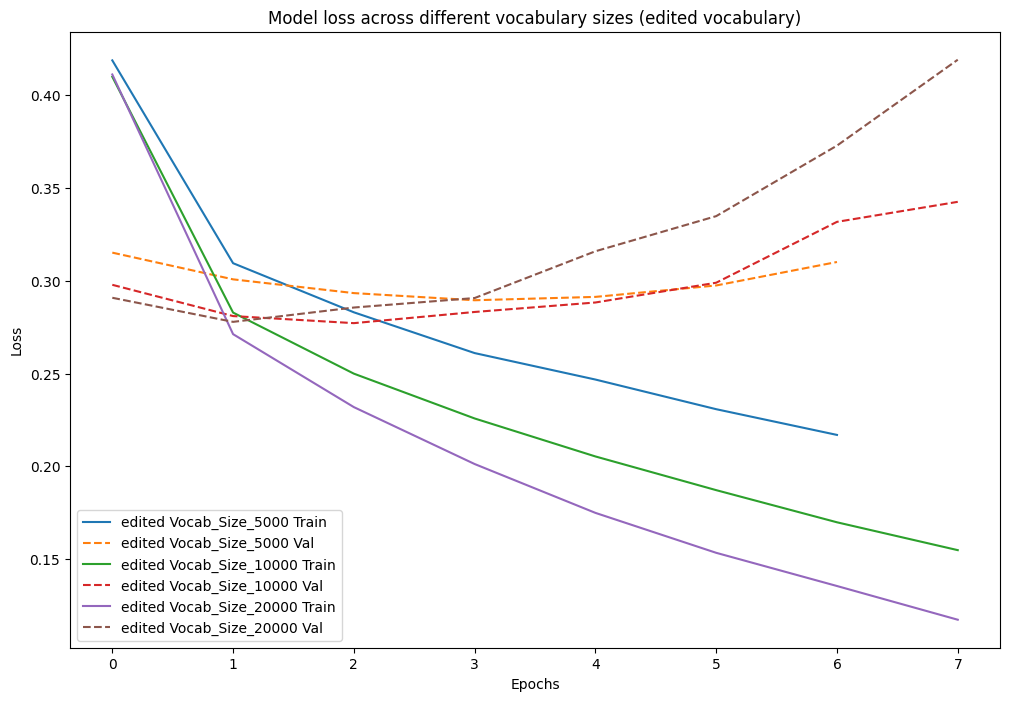

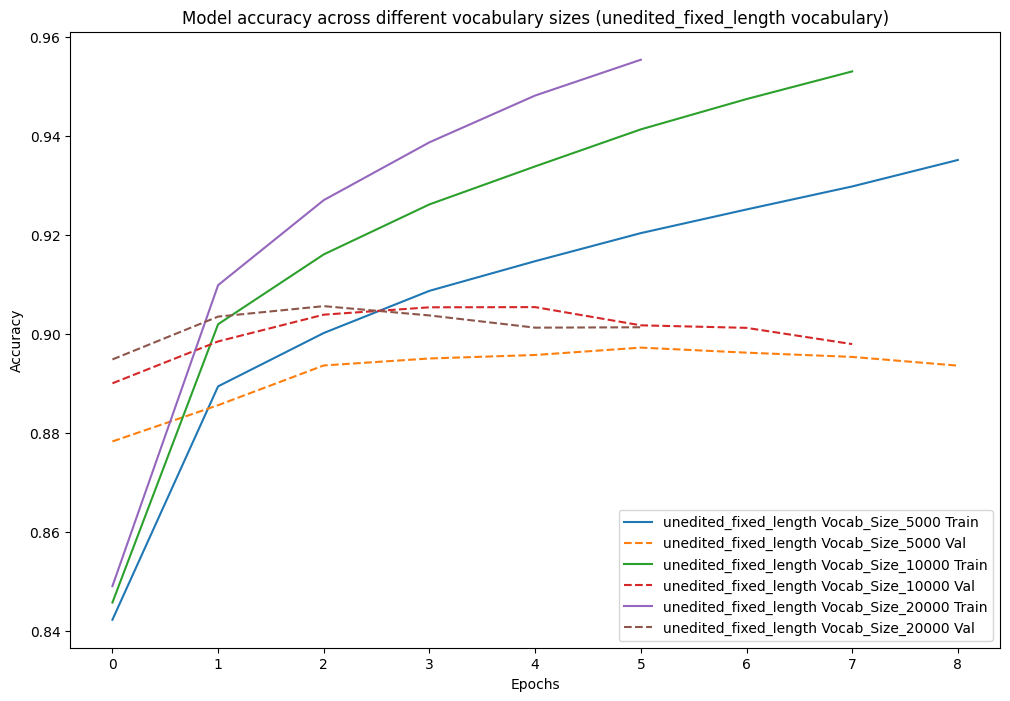

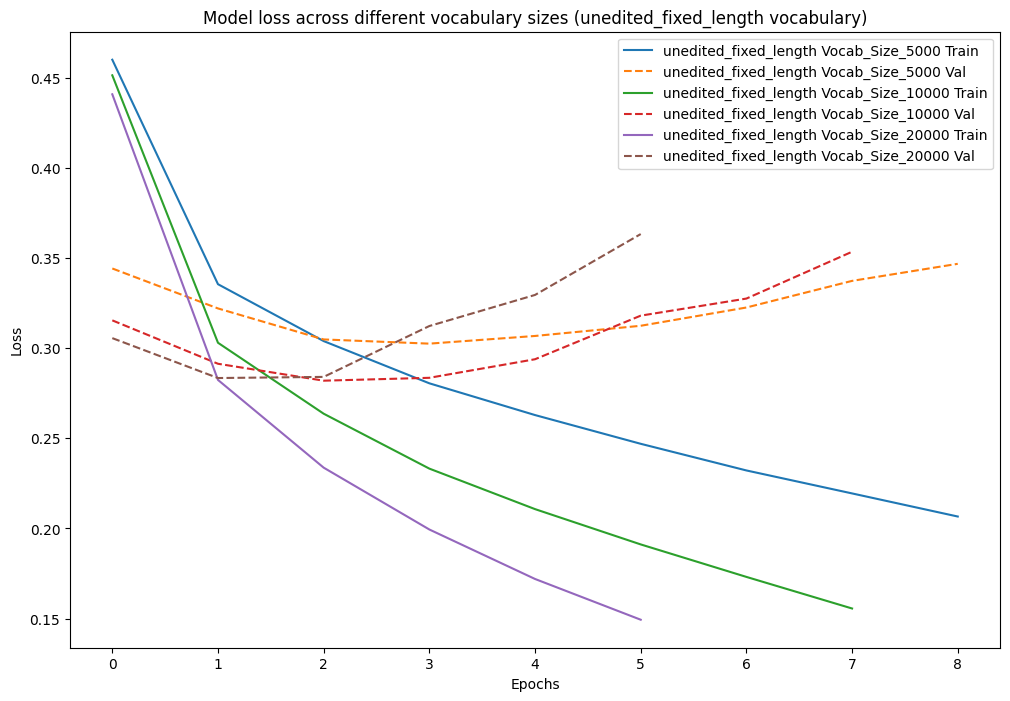

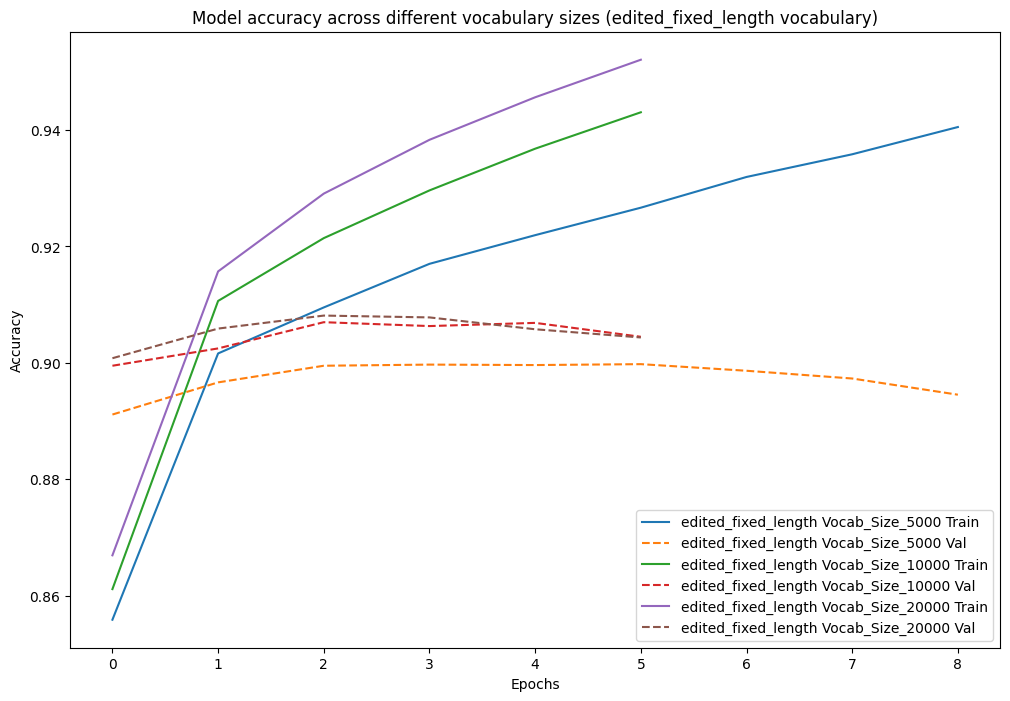

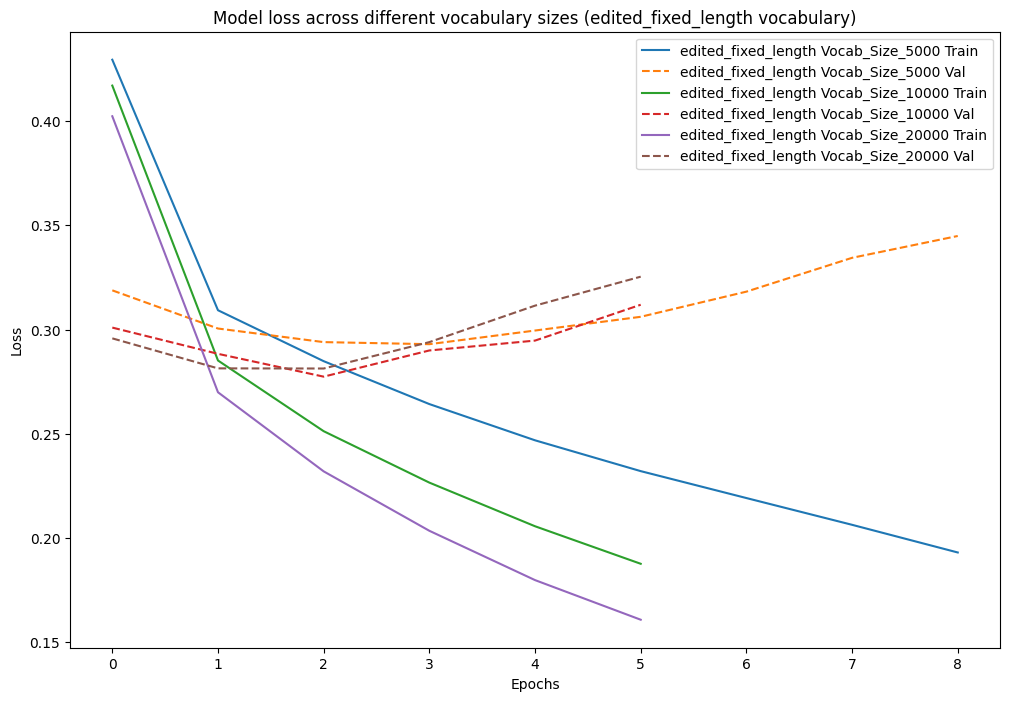

In [ ]:
# Plot accuracy and loss for different vocabulary sizes and experiments (bidirectional)
for experiment in experiments:
    experiment_name = experiment["name"]
    vocab_sizes = experiment["vocab_sizes"]

    plt.figure(figsize=(12, 8))
    for vocab_size in vocab_sizes:
        filtered_results = [res for res in all_results_bidirectional if res['experiment'] == experiment_name and res['vocab_size'] == vocab_size]
        if filtered_results:
            result = filtered_results[0]['results']
            history = result['history']
            plt.plot(history.history['accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
            plt.plot(history.history['val_accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')

    plt.title(f"Model accuracy across different vocabulary sizes ({experiment_name} vocabulary)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    for vocab_size in vocab_sizes:
        filtered_results = [res for res in all_results_bidirectional if res['experiment'] == experiment_name and res['vocab_size'] == vocab_size]
        if filtered_results:
            result = filtered_results[0]['results']
            history = result['history']
            plt.plot(history.history['loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
            plt.plot(history.history['val_loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')

    plt.title(f"Model loss across different vocabulary sizes ({experiment_name} vocabulary)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/458_M6_A3_lstm_bi_v3.ipynb"

Mounted at /content/drive
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/458_M6_A3_lstm_bi_v3.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/l